In [6]:
#Choose GPUs and CPUs

#If want to choose GPU to use
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#This will make it so that only the 0th GPU is visible to TensorFlow.
#In your case, you can choose any in the range [0, 3].
#If you wanted, for example, the 0th and 2nd GPUs to both be visible, replace "0" with "0,2"

import tensorflow as tf
from keras import backend as K
import keras

GPU=True
CPU=False
num_cores = 8

if GPU:
    num_GPU = 1
    num_CPU = 2
if CPU:
    num_CPU = num_cores
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
config.gpu_options.allow_growth = True

session = tf.Session(config=config)
K.set_session(session)


In [12]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np


from keras.layers import Conv2D, MaxPool2D, Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# Reload all data from before

In [8]:

from keras.datasets import mnist


# input image dimensions
img_rows, img_cols = 28, 28
num_classes=10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

train_dataset = x_train.astype('float32')
test_dataset = x_test.astype('float32')
train_dataset /= 255
test_dataset /= 255
print('train_dataset shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
train_labels = keras.utils.to_categorical(y_train, num_classes)
test_labels = keras.utils.to_categorical(y_test, num_classes)


train_dataset shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# O.K now try CNN using 1 inception module
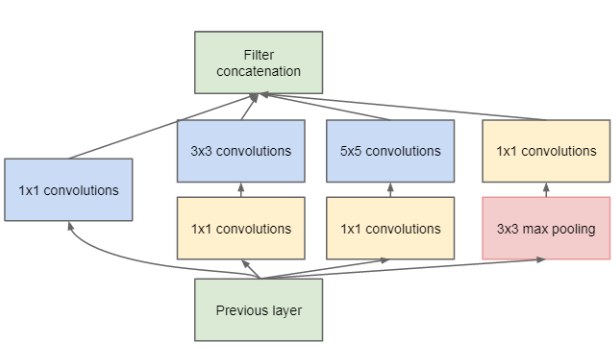

In [13]:
dims=train_dataset.shape
print (dims)
trainee=train_dataset.reshape(dims[0],dims[1],dims[2],1)
dims=test_dataset.shape
testee=test_dataset.reshape(dims[0],dims[1],dims[2],1)
print (trainee.shape)


K.clear_session()
np.random.seed(123)

#First block
input_img = Input(shape = (28, 28, 1))
tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(input_img)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)



output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
output = Flatten()(output)
out    = Dense(10, activation='softmax')(output)

model=Model(inputs = input_img, outputs = out)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())


#checkpoints=keras.callbacks.ModelCheckpoint('tmp_models/weights.{epoch:02d}.hdf5', monitor='val_loss', 
#                                verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history=model.fit(trainee, train_labels, batch_size=256, verbose=1, epochs=10, 
                  validation_split = 0.1)
                  #, callbacks=[checkpoints])
print ("Test performance")
score=model.evaluate(testee, test_labels, verbose=1)
print (score)

(60000, 28, 28, 1)
(60000, 28, 28, 1)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 64)    128         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 28, 28, 64)    128         input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 28, 28, 1)     0           input_1[0][0]                    
_____________________________________________________

98.5% isn't great, can we get better performance by maxpooling between inception modules?

In [21]:
dims=train_dataset.shape
print (dims)
trainee=train_dataset.reshape(dims[0],dims[1],dims[2],1)
dims=test_dataset.shape
testee=test_dataset.reshape(dims[0],dims[1],dims[2],1)
print (trainee.shape)


K.clear_session()
np.random.seed(123)

#First block
input_img = Input(shape = (28, 28, 1))
tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(input_img)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)


output1 = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
output1 = MaxPool2D(pool_size=(3,3), padding='same')(output1) 
        #Default stride size is same as pool size


#Second block
tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(output1)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(output1)
tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(output1)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)


output2 = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
output2 = MaxPool2D(pool_size=(3,3), padding='same')(output2) 


#Third block
tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(output2)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(output2)
tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(output2)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)

output3 = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)



output = Flatten()(output3)
out    = Dense(10, activation='softmax')(output)

model=Model(inputs = input_img, outputs = out)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())


#checkpoints=keras.callbacks.ModelCheckpoint('tmp_models/weights.{epoch:02d}.hdf5', monitor='val_loss', 
#                                verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history=model.fit(trainee, train_labels, batch_size=256, verbose=1, epochs=10, 
                  validation_split = 0.1)
                  #, callbacks=[checkpoints])
print ("Test performance")
score=model.evaluate(testee, test_labels, verbose=1)
print (score)

(60000, 28, 28, 1)
(60000, 28, 28, 1)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 64)    128         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 28, 28, 64)    128         input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 28, 28, 1)     0           input_1[0][0]                    
_____________________________________________________

Yes, we can! Accuracy is up to 99.4% with the Max Pooling layers between Inception modules